# Data processing of continuos glucose measurements

Notebook to process raw data. It will create train, validation and test datasets with a sampling frequency of 4 points per hour. The number of days for the historic data (features) is set in the variable `days`, and the number of hours to be predicted (target) in the variable `hours`.

The final datasets have shape (num_samples, `history`+`future`+2, num_features), being:

* `history` = number of points considered in the historic data points, calculated as `days` * 24 * 4
* `future` = number of points considered in the prediction, calculated as `hours` * 24 * 4

There are 5 features:

* Time interval: days counted starting from the end of the history of the sequence. Thus, for points in the history, this feature takes negatuve values, while for points in the future, it's positive.
* hour: hour of the day
* day of week: day of the week in numbers ('Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6)
* patient_id: numeric identifier for the patient, starting at zero.
* sugar level: recorded sugar level, scaled with min/max scaler.

Additionally, we add two columns for the scale (min and max) of every sequence, so that the actual shape of the datasets is (num_sequences, `history`+`future`+2, 5). The scale is thus repeated 5 times (one for each feature).

In [0]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
import pytz
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from multiprocessing import  Pool, cpu_count
from functools import partial

## Auxiliar methods for data processing 


### Choose features and format timestamps



In [0]:
def datetime_parser(series):
  possible_formats = ['%Y/%m/%d %H:%M:%S', 
                      '%Y/%m/%d %H:%M',
                      '%m-%d-%Y %I:%M %p', 
                      '%d.%m.%Y %H:%M',
                      '%Y-%m-%dT%H:%M:%S.%f%z',
                      '%Y-%m-%dT%H:%M:%S',
                      '%d/%m/%Y %H:%M'
                      ]

  raw_string_date = series.values[0]
  parsed_date = None
  for date_format in possible_formats:
    try:
        parsed_date = datetime.strptime(raw_string_date, date_format) # try to get the date
        break # if correct format, don't test any other formats
    except ValueError:
        pass # keep iterating

  if parsed_date:
    if '%z' not in date_format:
      out = pd.to_datetime(series, format=date_format, utc=True)
    else:
      out = pd.to_datetime(series, format=date_format)
  else:
    print('Warning: date format not obtained, we are going to allow pandas to infer it', raw_string_date)
    out = pd.to_datetime(series, infer_datetime_format=True)
  out = out.apply(lambda x: x.replace(microsecond=0).replace(tzinfo=None))
  
  return out

def load_df(files, outdir, outname, append=False, verbose=False):
  final_columns=['timestamp', 'aut_record', 'id', 'sampling']

  list_df = []
  sampling ={}
  for filename in files:
    i = int(filename[7:8])
    data_file = os.path.join(root, filename)
    # Data can be sampled in 5 or 15 minutes. We will sample the timeseries every 15 minutes
    sampling_rate = int(filename[22:23])
    sampling[i] = 3 if sampling_rate == 5 else 1

    dfs = pd.read_csv(data_file, sep=',', header=None, encoding='utf-8', 
                      names=final_columns[:-1])
    dfs['id'] = i
    dfs['sampling'] = sampling[i]

    # format records and drop nans
    dfs = dfs.dropna(inplace=False, subset=['aut_record'])
    dfs.aut_record = dfs.aut_record.values.astype(np.float)

    # drop duplicates
    dfs.drop_duplicates(inplace=True)
    
    # format timestamp
    dfs.timestamp = datetime_parser(dfs.timestamp)
    dfs = dfs.dropna(inplace=False, subset=['timestamp'])

    # sort values by timestamp
    dfs.sort_values(by=['timestamp'], inplace=True)
    dfs = dfs.reset_index()
    dfs.drop(columns=['index'], inplace=True)
    if verbose:
      print("For patient %s the df has shape %s" %(i, dfs.shape))
    list_df.append(dfs)

  dfs = pd.concat(list_df)

  # save df. If append == True, we first load previous data, and append the new df
  outfile = os.path.join(outdir, outname)
  dateformat = '%Y-%m-%d %H:%M:%S'
  if append:
    # update data that have already been processed
    dateparser=lambda x: pd.datetime.strptime(x, dateformat)
    old_dfs = pd.read_csv(os.path.join(outdir, outname), 
                          sep=',', 
                          header=0,
                          names=final_columns,
                          parse_dates=['timestamp'], 
                          date_parser=dateparser
                          )
    dfs_complete = pd.concat([old_dfs, dfs])
    print('You are going to process %s new rows' %(dfs.shape[0]))
    print("The total dataset has %s rows" %(dfs_complete.shape[0]))  
    # save data to csv
    dfs_complete.to_csv(outfile, sep=',', header=final_columns,
                        date_format=dateformat, index=False)
  else:
    print('You are going to process %s new rows' %(dfs.shape[0]))
    # save data to csv
    dfs.to_csv(outfile, sep=',', header=final_columns, date_format=dateformat, index=False)
  
  if verbose:
    print(dfs.head())
    print(dfs.dtypes)
  return dfs, sampling

### Sequence creation


In [0]:
one_day = np.timedelta64(1000000000*3600*24, 'ns')
one_hour = np.timedelta64(1000000000*3600, 'ns')
day_dict = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 
            'Friday': 4, 'Saturday': 5, 'Sunday': 6}

def get_time_data(data, idx, time_unit, zero_time=None):
  # get time feature, substract last time feature event, and normalize to time_unit
  
  # TODO we should already be working with datetimes
  ts = pd.to_datetime(data.timestamp.values[idx]) 
  hour = np.array([t.hour for t in ts])
  day = np.array([day_dict[t.day_name()] for t in ts])
  if not zero_time:
    zero_time = ts[-1]
  ts = np.array([(t-zero_time)/time_unit for t in ts])
  return hour, day, zero_time, ts

def get_sugar_data(data, idx, scaler=None):
  ys = data.aut_record.values[idx]
  if not scaler:
    min_ys = ys.min()
    max_ys = ys.max()
    scaler = (min_ys, max_ys)
  ys = (ys-scaler[0]) / (scaler[1] - scaler[0])
  return scaler, ys
    
def add_noise(y, noise=0.0):
  noisy_seq = np.random.normal(loc=0.0, scale=noise, size=y.size)
  y_noisy = y + noisy_seq
  return y_noisy
        
def create_sequence(data, start, history, future, feature_steps=1, label_steps=1, 
                    time_unit=one_day, noise=0.1, day_dict=day_dict):
  # get feature and label index ranges
  feature_range = np.arange(start=start, stop=start+history, step=feature_steps)
  label_range = np.arange(start=start+history, stop=start+history+future, step=label_steps)
  
  # get features
  # set scaler=(0.0, 1.0) to avoid scaling
  scaler = None
  hour_feature, day_feature, zero_time, ts_feature = get_time_data(data, feature_range, time_unit, 
                                                                    zero_time=None)
  scaler, ys_feature = get_sugar_data(data, feature_range, scaler=scaler)
  ys_feature_noisy = add_noise(ys_feature, noise) if noise > 0. else ys_feature
  id_feature = data.id.values[feature_range]
  # put together the id, sugar_level, hour, day and time_interval
  features = [ts_feature, hour_feature, day_feature, id_feature, ys_feature_noisy]
  comb_feature = np.stack(arrays=features, axis=1)
  
  # get labels
  hour_label, day_label, _, ts_label = get_time_data(data, label_range, time_unit, zero_time=zero_time)
  _, ys_label = get_sugar_data(data, label_range, scaler=scaler)
  id_label = data.id.values[label_range]
  labels = [ts_label,hour_label, day_label, id_label, ys_label]
  comb_label = np.stack(arrays=labels, axis=1)
  
  return ys_feature, comb_feature, comb_label, scaler        

def verify_sequence(feature, label, feature_steps, label_steps, min_v, max_v, 
                    hours_in_day=24.0, sampling=1.0):
  max_time_feature = feature_steps / sampling / 4.0 / hours_in_day
  max_time_label = label_steps / sampling / 4.0 / hours_in_day

  max_feature = -np.min(feature[:, 0]) / max_time_feature
  max_label = np.max(label[:, 0]) / max_time_label

  cond1 =  min_v <= max_feature <= max_v
  cond2 =  min_v <= max_label <= max_v

  return max_time_feature, max_time_label, max_feature, max_label, cond1, cond2

def rescale(y, scale):
  return scale[0] + (scale[1] - scale[0])*y

### Split in train, vad and test


In [0]:
def add_sequences(starts, data, history, future, feature_steps, label_steps, replace,
                  noise, time_unit, day_dict, max_tol, min_tol):
    timesteps = history//feature_steps + future//label_steps
    out = np.zeros(shape=(starts.size, timesteps+2, 5), dtype=np.float32)
    k = 0
    for start in starts:
        _, ynf, yl, scale = create_sequence(data, start=start, history=history, future=future, 
                                     feature_steps=feature_steps, label_steps=label_steps, 
                                     time_unit=time_unit, noise=noise, day_dict=day_dict)
        
        # conditions on maximum time
        max_time_feature, max_time_label, max_feature, max_label, cond1, cond2 = \
            verify_sequence(ynf, yl, history, future, min_tol, max_tol, sampling=feature_steps)

        if cond1 and cond2:
            out[k] = np.concatenate([ynf, yl, np.tile(list(scale), [5, 1]).T], axis=0)
            k += 1
        else:
            out = np.delete(out, k, 0)
    return out

def parallelize_add_sequences(starts, **kwargs):
    n_cores= cpu_count()
    starts_split = np.array_split(starts, n_cores)
    pool = Pool(n_cores)
    partial_func = partial(add_sequences, **kwargs)
    out = np.concatenate(pool.map(partial_func, starts_split), axis=0)
    pool.close()
    pool.join()
    return out

def create_dataset(data, num_samples, min_idx, max_idx, history, future, 
                   feature_steps=1, label_steps=1, replace=False,
                   noise=0.1, time_unit=one_day, day_dict=day_dict, 
                   max_tol=1.2, min_tol=0.8,
                   seed=1098, verbose=False):
    # get all possible start indices
    indices = data.index[min_idx: max_idx-history-future+1]
    # generate num_samples starting indices
    np.random.seed(seed)
    starts = np.random.choice(indices, size=num_samples, replace=replace)
    
    inputs = dict(data=data, history=history, future=future, 
                  feature_steps=feature_steps, label_steps=label_steps, 
                  replace=replace, noise=noise, time_unit=time_unit, 
                  day_dict=day_dict, max_tol=max_tol, min_tol=min_tol)
    out= parallelize_add_sequences(starts, **inputs)
    
    if verbose:
        s = "We have added %s sequences (out of %s)." 
        print(s %(out.shape[0], num_samples))
    return out

def generate_train_vad_test(dfs, hours, days, noise, max_tol, min_tol, 
                            train_samples_no_replace, train_samples_replace, 
                            outdir, seed, append, verbose):
  if verbose:
    print('*'*60)
    print('*'*60)
    print('Noise %s, days %s, hours %s' %(noise, days, hours))
    print('*'*60)
    print('*'*60)

  # boolean to create sequences with replace. It only makes sense when adding noise
  replace = False if noise == 0.0 else True

  train, vad, test = [], [], []
  for id_ in dfs.id.unique():
    if verbose:
      print('*'*60)
      print('Patient id=%s' %id_)
      print('*'*60)

    # filter data
    df_patient = dfs[dfs.id == id_].reset_index()
    df_patient.drop(columns=['index'], inplace=True)
    size = df_patient.shape[0]

    # sampling: 1 corresponds to 15 minutes, 3 to 5 minutes
    history_steps = sampling[id_] 
    future_steps = sampling[id_]
    # data is sampled every 5 or 15 minutes. Thus, there are 12 or 4 measurements per hour
    history = int(days * 24 * 4 * history_steps)  # a history of X days
    future = int(hours * 4 * future_steps)  # a history of X hours

    # train set size
    train_max_idx = int(size*0.8)
    if replace:
        num_samples_train = int(train_samples_replace * (train_max_idx-history-future))
    else:
        num_samples_train = int(train_samples_no_replace * (train_max_idx-history-future))

    # validation set size
    vad_max_id = int(size*0.9)
    num_samples_vad = vad_max_id - train_max_idx - history - future

    # testing set size
    num_samples_test = size - vad_max_id - history - future

    assert num_samples_vad >= 10, "Error: There are less than 10 sequences in validation"
    assert num_samples_test >= 10, "Error: There are less than 10 sequences in test"

    if verbose:
      print("Creating train dataset; we will sample %s sequences." %num_samples_train)
    train_patient = create_dataset(df_patient, num_samples=num_samples_train, 
                                   min_idx=0, max_idx=train_max_idx, 
                                   history=history, future=future, 
                                   feature_steps=history_steps, label_steps=future_steps,
                                   replace=replace, noise=noise, time_unit=one_day, 
                                   max_tol=max_tol, min_tol=min_tol, seed=seed, 
                                   verbose=verbose)

    # In the validation and test datasets we do not use replace, nor add noise
    if verbose:
      print("Creating validation dataset; we will sample %s sequences." %num_samples_vad)
    vad_patient = create_dataset(df_patient, num_samples=num_samples_vad, 
                                 min_idx=train_max_idx, max_idx=vad_max_id, 
                                 history=history, future=future, 
                                 feature_steps=history_steps, label_steps=future_steps,
                                 replace=False, noise=0.0, time_unit=one_day, 
                                 max_tol=max_tol, min_tol=min_tol, seed=seed, 
                                 verbose=verbose)

    if verbose:
      print("Creating test dataset; we will sample %s sequences." %num_samples_test)
    test_patient = create_dataset(df_patient, num_samples=num_samples_test, 
                                  min_idx=vad_max_id, max_idx=size, 
                                  history=history, future=future, 
                                  feature_steps=history_steps, label_steps=future_steps,
                                  replace=False, noise=0.0, time_unit=one_day, 
                                  max_tol=max_tol, min_tol=min_tol, seed=seed, 
                                  verbose=verbose)

    if verbose:
      msg = 'For patient id={id_}, the size of the train, vad and test sets is '
      msg += '({train}, {vad}, {test}), respectively.'
      msg = msg.format(id_=id_, train=train_patient.shape[0], 
                       vad=vad_patient.shape[0], test=test_patient.shape[0])
      print(msg)

    train.append(train_patient)
    vad.append(vad_patient)
    test.append(test_patient)

  train = np.concatenate(train, axis=0)
  vad = np.concatenate(vad, axis=0)
  test = np.concatenate(test, axis=0)

  name = "{{dataset}}_noise_{noise}_feature-{days}days_label-{hours}hours_replace{replace}.npy" 
  name = name.format(noise=noise, days=days, hours=hours, replace=replace)
  if append:
    train_old = np.load(os.path.join(outdir, name.format(dataset='train')))
    vad_old = np.load(os.path.join(outdir, name.format(dataset='vad')))
    test_old = np.load(os.path.join(outdir, name.format(dataset='test')))
    
    train = np.concatenate([train_old, train], axis=0)
    vad = np.concatenate([vad_old, vad], axis=0)
    test = np.concatenate([test_old, test], axis=0)

  # we always show this message 
  msg = 'The final size of the train, vad and test sets is ({train}, {vad}, {test}), respectively.'
  msg = msg.format(train=train.shape[0], vad=vad.shape[0], test=test.shape[0])
  print(msg)

  print('Saving')
  np.save(os.path.join(outdir, name.format(dataset='train')), train)
  np.save(os.path.join(outdir, name.format(dataset='vad')), vad)
  np.save(os.path.join(outdir, name.format(dataset='test')), test)

  return train, vad, test

## Porcess data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# set the root data where you have uncompress the zip file
root = '/content/drive/My Drive/Colab Notebooks/sugar_level_prediction/data/'

# list csv files with raw data. Make sure you only have the csv files 
# contained in the compressed zip file in root folder
files = [f for f in os.listdir(root) if f.endswith(".csv")]

# folder to store processed files
outdir = os.path.join(root, 'processed')
os.makedirs(outdir, exist_ok=True)

In [0]:
hours = 1
noise = 0.0
days = 3
seed = 17082
max_tol = 1.1
min_tol = 0.9
train_samples_no_replace =  1.0
train_samples_replace = 3    

# Change append to true if you want to process just some specific files
append = False
verbose = True

dfs, sampling = load_df(files, outdir=outdir, outname='raw_data.csv', 
                        append=append, verbose=verbose)
print(sampling)
dfs.head()

train, vad, test = generate_train_vad_test(dfs, hours, days, noise, max_tol, 
  min_tol, train_samples_no_replace, train_samples_replace, outdir, seed, 
  append=append, verbose=verbose)

For patient 8 the df has shape (102396, 4)
For patient 9 the df has shape (43297, 4)
For patient 7 the df has shape (26708, 4)
For patient 6 the df has shape (24816, 4)
For patient 1 the df has shape (20129, 4)
For patient 2 the df has shape (12030, 4)
For patient 4 the df has shape (19798, 4)
For patient 3 the df has shape (106623, 4)
For patient 0 the df has shape (76114, 4)
For patient 5 the df has shape (78812, 4)
You are going to process 510723 new rows
            timestamp  aut_record  id  sampling
0 2019-01-01 00:04:39       167.0   8         3
1 2019-01-01 00:09:40       168.0   8         3
2 2019-01-01 00:14:38       169.0   8         3
3 2019-01-01 00:19:38       171.0   8         3
4 2019-01-01 00:24:38       176.0   8         3
timestamp     datetime64[ns]
aut_record           float64
id                     int64
sampling               int64
dtype: object
{8: 3, 9: 1, 7: 3, 6: 1, 1: 1, 2: 1, 4: 3, 3: 3, 0: 1, 5: 3}
**********************************************************

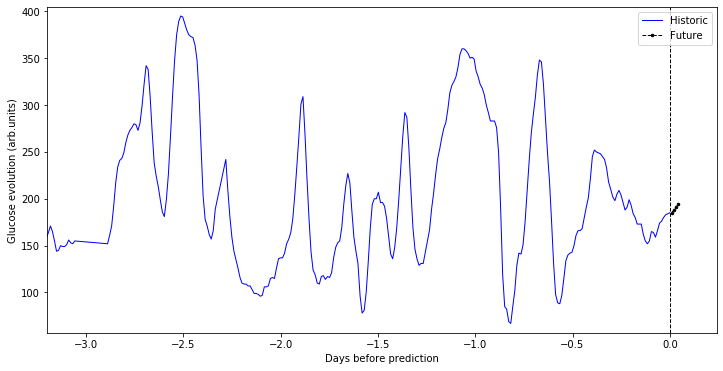

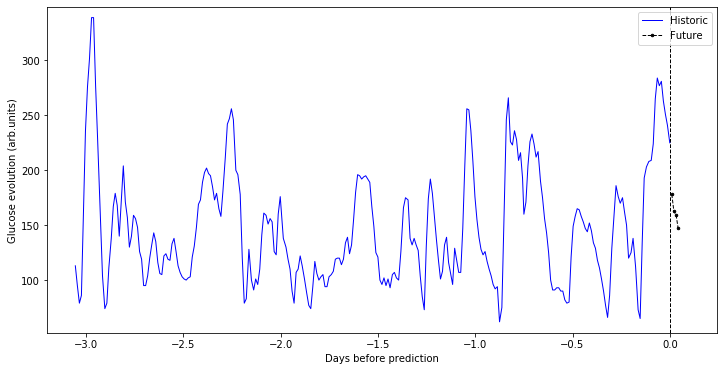

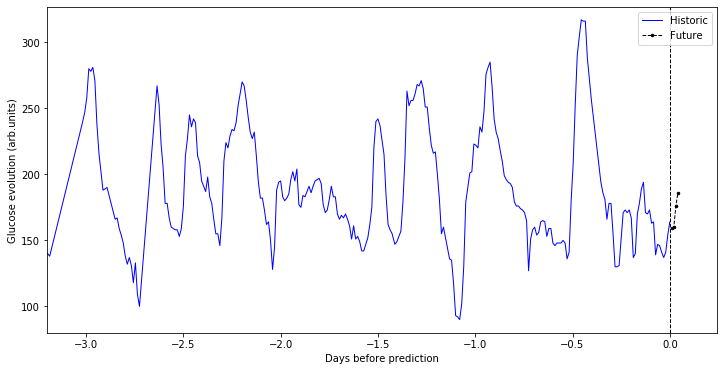

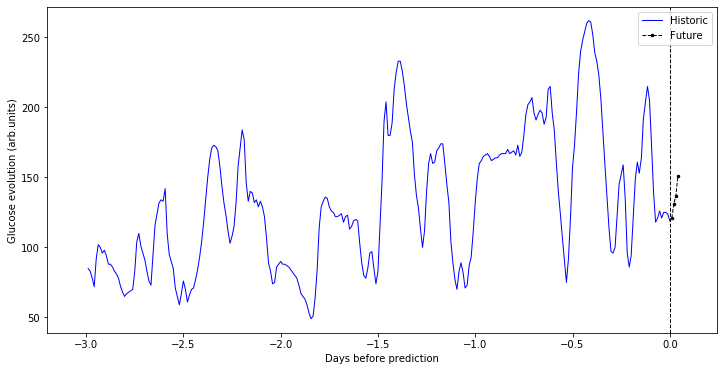

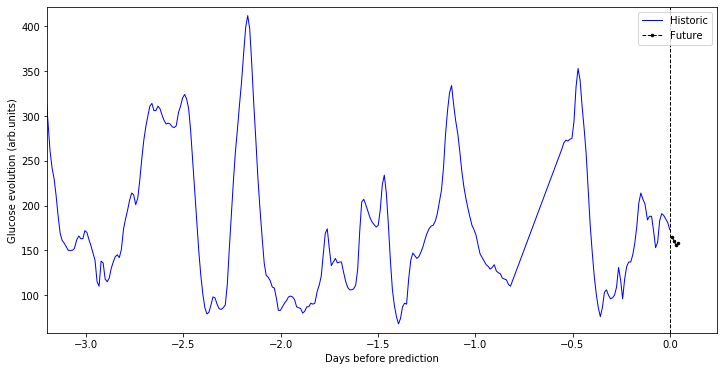

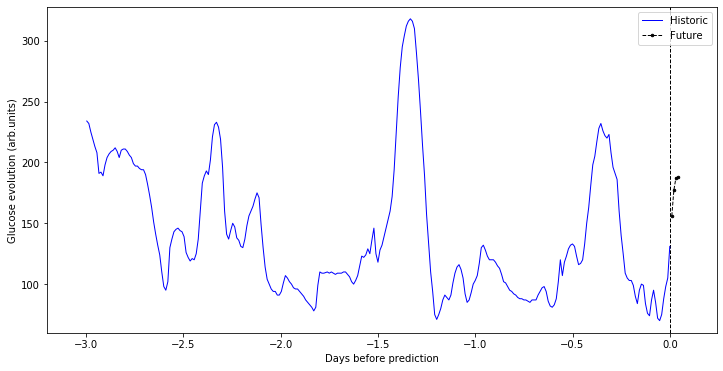

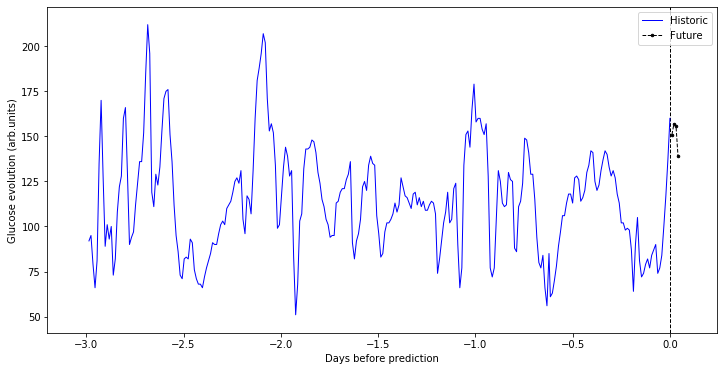

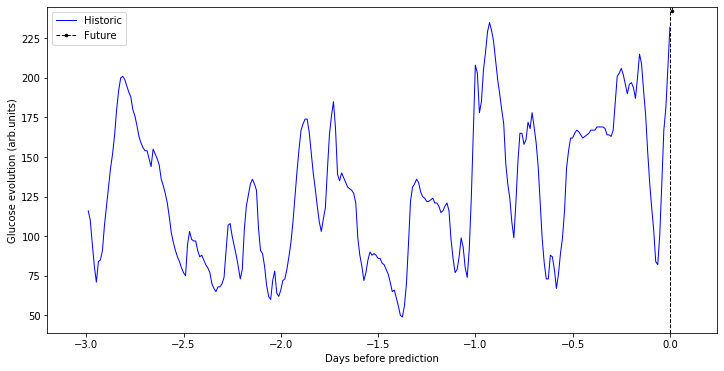

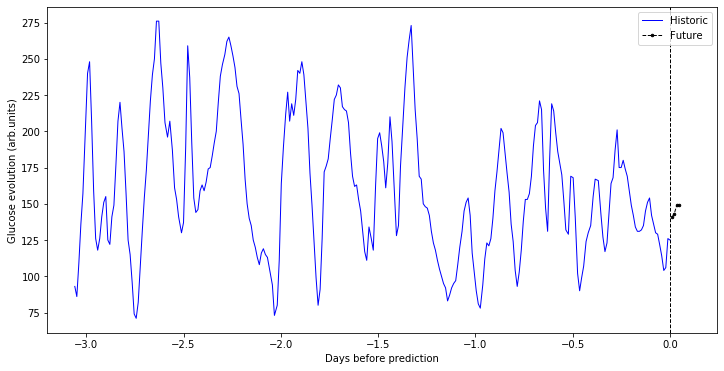

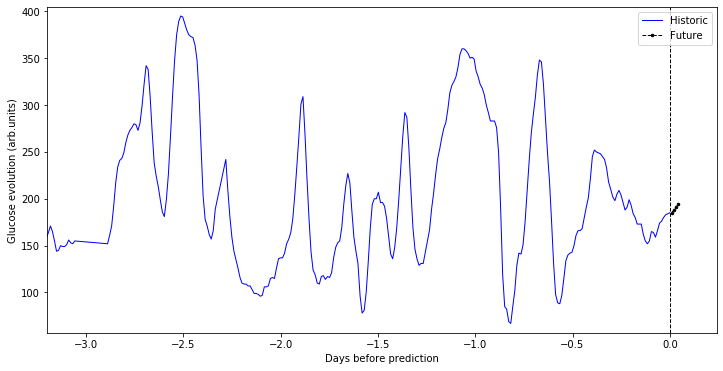

In [0]:
# we need this variables for plotting some sequences
history = int(days * 24 * 4)
future = int(hours * 4)
assert vad.shape[1] == history + future + 2

for _ in np.arange(10):

  plt.figure(figsize=(12, 6))

  idx=np.random.randint(low=0, high=vad.shape[0])
  xf, xl = vad[idx, :history, 0], vad[idx, history:history+future, 0]
  yf, yl = vad[idx, :history, -1], vad[idx, history:history+future, -1]
  
  scale = vad[idx, history+future:history+future+2, -1]
  yf = rescale(yf, scale)
  yl = rescale(yl, scale)

  ymin = yf.min()-10
  ymax = yf.max()+10

  plt.plot(xf, yf, '-b', markersize=2, linewidth=1, label='Historic')
  plt.plot(xl, yl, '.--k', markersize=5, linewidth=1, label='Future')
  plt.vlines(x=0, ymin=ymin, ymax=ymax, colors='k', linewidth=1, linestyles='--')

  plt.ylim(ymin, ymax)
  plt.xlim(-history/4/24 - 0.2, future/4/24 + 0.2)
  
  plt.ylabel('Glucose evolution (arb.units)')
  plt.xlabel('Days before prediction')
  plt.legend(loc='best')
  plt.show()